In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import trange

$\frac{dU}{dt} + c\frac{dU}{dx} = 0$

In [2]:
# space-derivative approximation functions
def right_1(U, h):
    return (U[1:] - U[:-1]) / h, 1, None
def right_2(U, h):
    return (U[0:-2] - 4 * U[1:-1] + 3 * U[2:]) / h / 2., 2, None
def central_2(U, h):
    return (U[2:] - U[:-2]) / 2. / h, 1, -1
def central_4(U, h):
    return (U[:-4] - U[4:] + 8. * (U[3:-1] - U[1:-3])) / 12. / h, 2, -2
def central_6(U, h):
    return (U[6:] - U[:-6] + 9. * (U[1:-5] - U[5:-1]) + 45. * (U[4:-2] - U[2:-4])) / 60. / h, 3, -3
def weno_5(U, h):
    N = U.size
    C = np.array([[1./3., 5./6., -1./6.],
                  [-1./6., 5./6., 1./3.],
                  [1./3., -7./6., 11./6.]])
    Beta = np.zeros((3, N - 6))
    Beta[0, :] = 13./12. * (U[3:-3] - 2. * U[4:-2] + U[5:-1]) ** 2 + 1./4. * (3. * U[3:-3] - 4. * U[4:-2] + U[5:-1]) ** 2
    Beta[1, :] = 13./12. * (U[2:-4] - 2. * U[3:-3] + U[4:-2]) ** 2 + 1./4. * (U[2:-4] - U[4:-2]) ** 2
    Beta[2, :] = 13./12. * (U[1:-5] - 2. * U[2:-4] + U[3:-3]) ** 2 + 1./4. * (U[1:-5] - 4. * U[2:-4] + 3. * U[3:-3]) ** 2
    
    d = np.array([0.3, 0.6, 0.1])
    eps = 1e-20
    alpha = d / (eps + Beta.T) ** 2
    W = alpha.T / np.sum(alpha, axis = 1)
    
    U_R = np.zeros_like(U)
    U_R[3:-3] += W[0, :] * np.convolve(U[3:-1], C[0, ::-1], 'valid') + \
                 W[1, :] * np.convolve(U[2:-2], C[1, ::-1], 'valid') + \
                 W[2, :] * np.convolve(U[1:-3], C[2, ::-1], 'valid')
    U_big = np.zeros(N + 1)
    U_big[1:] = U_R
    return (U_big[1:] - U_big[:-1]) / h, 0, None

In [3]:
# time-derivative approximation functions
def upwind(U, h, c, r, Deriv):
    dt = r * h
    temp, idx_l, idx_r = Deriv(U, h)
    U_n = U[idx_l:idx_r] - c * dt * temp
    return U_n, dt, idx_l, idx_r
def heun(U, h, c, r, Deriv):
    dt = r * h
    k1 = np.zeros_like(U)
    k2 = np.zeros_like(U)
    temp1, idx_l, idx_r = Deriv(U, h)
    k1[idx_l:idx_r] = U[idx_l:idx_r] - c * dt * temp1 / 3.
    temp2, idx_l, idx_r= Deriv(k1, h)
    k2[idx_l:idx_r] = U[idx_l:idx_r] - 2. * c * dt * temp2 / 3.
    temp3, idx_l, idx_r = Deriv(k2, h)
    return 0.25 * U[idx_l:idx_r] + 0.75 * k1[idx_l:idx_r] - 0.75 * c * dt * temp3, dt, idx_l, idx_r
def runge_kutta_2(U, h, c, r, Deriv):
    dt = r * h
    k1 = np.zeros_like(U)
    k2 = np.zeros_like(U)
    temp1, idx_l, idx_r = Deriv(U, h)
    k1[idx_l:idx_r] = -temp1
    temp2, idx_l, idx_r = Deriv(U + c * dt * k1, h)
    k2[idx_l:idx_r] = -temp2
    return U + 0.5 * c * dt * k1 + 0.5 * c * dt * k2, dt, 0, None
def runge_kutta_3(U, h, c, r, Deriv):
    dt = r * h
    k1 = np.zeros_like(U)
    k2 = np.zeros_like(U)
    k3 = np.zeros_like(U)
    temp1, idx_l, idx_r = Deriv(U, h)
    k1[idx_l:idx_r] = -temp1
    temp2, idx_l, idx_r = Deriv(U + c * dt * k1 / 3., h)
    k2[idx_l:idx_r] = -temp2
    temp3, idx_l, idx_r = Deriv(U + 2. * c * dt * k2 / 3., h)
    k3[idx_l:idx_r] = -temp3
    return U + 0.25 * c * dt * k1 + 0.75 * c * dt * k3, dt, 0, None
def runge_kutta_4(U, h, c, r, Deriv):
    dt = r * h
    k1 = np.zeros_like(U)
    k2 = np.zeros_like(U)
    k3 = np.zeros_like(U)
    k4 = np.zeros_like(U)
    temp1, idx_l, idx_r = Deriv(U, h)
    k1[idx_l:idx_r] = -temp1
    temp2, idx_l, idx_r = Deriv(U + c * dt * k1 / 2., h)
    k2[idx_l:idx_r] = -temp2
    temp3, idx_l, idx_r = Deriv(U + c * dt * k2 / 2., h)
    k3[idx_l:idx_r] = -temp3
    temp4, idx_l, idx_r = Deriv(U + c * dt * k3, h)
    k4[idx_l:idx_r] = -temp4
    return U + c * dt * k1 / 6. + c * dt * k2 / 3. + c * dt * k3 / 3. + c * dt * k4 / 6., dt, 0, None
def runge_kutta_5(U, h, c, r, Deriv):
    dt = r * h
    k1 = np.zeros_like(U)
    k2 = np.zeros_like(U)
    k3 = np.zeros_like(U)
    k4 = np.zeros_like(U)
    k5 = np.zeros_like(U)
    k6 = np.zeros_like(U)
    temp1, idx_l, idx_r = Deriv(U, h)
    k1[idx_l:idx_r] = -temp1
    temp2, idx_l, idx_r = Deriv(U + c * dt * k1 / 4., h)
    k2[idx_l:idx_r] = -temp2
    temp3, idx_l, idx_r = Deriv(U + c * dt * k1 / 8. + c * dt * k2 / 8., h)
    k3[idx_l:idx_r] = -temp3
    temp4, idx_l, idx_r = Deriv(U + c * dt * k3 / 2., h)
    k4[idx_l:idx_r] = -temp4
    temp5, idx_l, idx_r = Deriv(U + 3. * c * dt * k1 / 16. - 3. * c * dt * k2 / 8. + 3. * c * dt * k3 / 8. + 9. * c * dt * k4 / 16., h)
    k5[idx_l:idx_r] = -temp5
    temp6, idx_l, idx_r = Deriv(U - 3. * c * dt * k1 / 7. + 8. * c * dt * k2 / 7. + 6. * c * dt * k3 / 7. - 12. * c * dt * k4 / 7. + 8. * c * dt * k5 / 7., h)
    k6[idx_l:idx_r] = -temp6
    return U + 7. * c * dt * k1 / 90. + 16. * c * dt * k3 / 45. + 2. * c * dt * k4 / 15. + 16. * c * dt * k5 / 45. + 7. * c * dt * k6 / 90., dt, 0, None
def runge_kutta_7(U, h, c, r, Deriv):
    dt = r * h * h
    k1 = np.zeros_like(U)
    k2 = np.zeros_like(U)
    k3 = np.zeros_like(U)
    k4 = np.zeros_like(U)
    k5 = np.zeros_like(U)
    k6 = np.zeros_like(U)
    k7 = np.zeros_like(U)
    k8 = np.zeros_like(U)
    k9 = np.zeros_like(U)
    temp1, idx_l, idx_r = Deriv(U, h)
    k1[idx_l:idx_r] = -temp1
    temp2, idx_l, idx_r = Deriv(U + c * dt * k1  / 6.0, h)
    k2[idx_l:idx_r] = -temp2
    temp3, idx_l, idx_r = Deriv(U + c * dt * k2  / 3.0, h)
    k3[idx_l:idx_r] = -temp3
    temp4, idx_l, idx_r = Deriv(U + c * dt * k1  / 8.0 + c * dt * k3 * 3.0  / 8.0, h)
    k4[idx_l:idx_r] = -temp4
    temp5, idx_l, idx_r = Deriv(U + c * dt * k1 * 148.0  / 1331.0 + c * dt * k3 * 150.0  / 1331.0 - c * dt * k4 * 56.0  / 1331.0, h)
    k5[idx_l:idx_r] = -temp5
    temp6, idx_l, idx_r = Deriv(U - c * dt * k1 * 404.0  / 243.0 - c * dt * k3 * 170.0  / 27.0 + c * dt * k4 * 4024.0  / 1701.0 + c * dt * k5 * 10648.0  / 1701.0, h)
    k6[idx_l:idx_r] = -temp6
    temp7, idx_l, idx_r = Deriv(U + c * dt * k1 * 2466.0  / 2401.0 + c * dt * k3 * 1242.0  / 343.0 - c * dt * k4 * 19176.0  / 16807.0 - c * dt * k5 * 51909.0  / 16807.0 + c * dt * k6 * 1053.0  / 2401.0, h)
    k7[idx_l:idx_r] = -temp7
    temp8, idx_l, idx_r = Deriv(U + c * dt * k1 * 5.0  / 154.0 + c * dt * k4 * 96.0  / 539.0 - c * dt * k5 * 1815.0  / 20384.0 - c * dt * k6 * 405.0  / 2464.0 + c * dt * k7 * 49.0  / 1144.0, h)
    k8[idx_l:idx_r] = -temp8
    temp9, idx_l, idx_r = Deriv(U - c * dt * k1 * 113.0  / 32.0 - c * dt * k3 * 195.0  / 22.0 + c * dt * k4 * 32.0  / 7.0 + c * dt * k5 * 29403.0  / 3584.0 - c * dt * k6 * 729.0  / 512.0 + c * dt * k7 * 1029.0  / 1408.0 + c * dt * k8 * 21.0  / 16.0, h)
    k9[idx_l:idx_r] = -temp9
    return U + c * dt * k4 * 32.0  / 105.0 + c * dt * k5 * 1771561.0  / 6289920.0 + c * dt * k6 * 243.0  / 2560.0 + c * dt * k7 * 16807.0  / 74880.0 + c * dt * k8 * 77.0  / 1440.0 + c * dt * k9 * 11.0  / 270.0, dt, 0, None

In [4]:
class Solver:
    def __init__(self, h, c, L, r, T = 100., pw = 6):
        self.h = h
        self.c = c
        self.L = L
        self.r = r
        self.T = T
        self.Nx = int(L / h)
        self.pw = pw
        self.U = np.zeros(self.Nx)
        self.U_ex = np.zeros(self.Nx)
    def initial(self):
        x0 = int(self.Nx / 2) - int(20 / self.h)
        x1 = x0 + int(40 / self.h)
        x = np.linspace(0, self.L, self.Nx)
        self.U[x0:x1] = np.abs(np.sin((x[x0:x1] - x[x0]) * np.pi / (x[x1] - x[x0])) ** self.pw)
        cTh = int(self.c * self.T / self.h)
        self.U_ex[x0 + cTh:x1 + cTh] = np.abs(np.sin((x[x0 + cTh:x1 + cTh] - x[x0 + cTh]) * np.pi / (x[x1 + cTh] - x[x0 + cTh])) ** self.pw)
    def solve(self, F, Deriv):
        #t = 0
        #while t < self.T:
        #    temp, dt, idx_l, idx_r = F(self.U, self.h, self.c, self.r, Deriv)
        #    self.U[idx_l : idx_r] = temp
        #    t += dt
        temp, dt, idx_l, idx_r = F(self.U, self.h, self.c, self.r, Deriv)
        self.U[idx_l : idx_r] = temp
        Nt = int(self.T / dt)
        for i in trange(Nt):
            if i == 0: continue
            temp, dt, idx_l, idx_r = F(self.U, self.h, self.c, self.r, Deriv)
            self.U[idx_l : idx_r] = temp
    def error(self):
        x0 = int(self.Nx / 2) - int(20 / self.h)
        x1 = x0 + int(40 / self.h)
        cTh = int(self.c * self.T / self.h)
        return np.sqrt(np.sum((self.U[x0 + cTh: x1 + cTh] - self.U_ex[x0 + cTh: x1 + cTh]) ** 2 * self.h))
        #return np.mean((self.U[x0 + cTh: x1 + cTh] - self.U_ex[x0 + cTh: x1 + cTh]) ** 2 * self.h)
    def draw(self, axs, ylabel = 'U'):
        x = np.linspace(0, self.L, self.Nx)
        x0 = int(self.Nx / 2) - int(20 / self.h)
        x1 = x0 + int(40 / self.h)
        cTh = int(self.c * self.T / self.h)
        axs.plot(x[x0 + cTh - 100: x1 + cTh + 100], self.U[x0 + cTh - 100: x1 + cTh + 100], label = ylabel);
        axs.plot(x[x0 + cTh - 100: x1 + cTh + 100], self.U_ex[x0 + cTh - 100: x1 + cTh + 100], '--', label = 'h = ' + str(self.h));
        axs.set_xlabel('x')
        axs.set_ylabel('y')
        axs.grid()
        axs.legend()

In [5]:
def init_H_as_power_of_2(n):
    H = np.array([2 ** -i for i in range(n)])
    return H

In [6]:
def least_squares_linear(x, y):
    # y = a * x + b
    n = x.size
    sx2 = np.sum(x ** 2)
    sx = np.sum(x)
    sy = np.sum(y)
    sxy = np.sum(x * y)
    d = n * sx2 - sx * sx
    da = n * sxy - sx * sy
    db = sx2 * sy - sx * sxy
    return da / d, db / d

In [7]:
def make_error_packs(H, c, L, r, deriv_t, deriv_x, T = 100., pw = 6, draw = False):
    N = len(H)
    #dt_size, dx_size = len(deriv_t), len(deriv_x)
    err_pack = []
    if draw: fig, axs = plt.subplots(N, 1, figsize = (10, 8))
    for dt in deriv_t:
        for dx in deriv_x:
            errs = np.zeros(N)
            for i, h in enumerate(H):
                solver = Solver(h, c, L, r, T, pw)
                solver.initial()
                solver.solve(dt, dx)
                errs[i] = solver.error()
                ylabel = str(dt).split(' ')[1] + '+' + str(dx).split(' ')[1]
                if draw: solver.draw(axs[i], ylabel)
            err_pack.append(errs)
    return err_pack

In [8]:
def plot_errors(H, errs_packs):
    plt.figure(figsize = (10, 10))
    plt.grid()
    plt.title('Errors')
    plt.xlabel('ln(h)')
    plt.ylabel('ln(err)')
    for err in errs_packs:
        a, b = least_squares_linear(np.log(H), np.log(err))
        plt.scatter(np.log(H), np.log(err), label = 'order = ' + str(a));
        plt.plot(np.log(H), a * np.log(H) + b, '--', color = 'black')
        plt.legend()
        #print(np.log(err[-2] / err[-1]) / np.log(2.))


In [16]:
from central_diference import generate_cd
cd_2 = generate_cd(2).get_cd_as_function()
cd_4 = generate_cd(4).get_cd_as_function()
cd_6 = generate_cd(6).get_cd_as_function()
cd_8 = generate_cd(8).get_cd_as_function()
cd_10 = generate_cd(10).get_cd_as_function()
cd_12 = generate_cd(12).get_cd_as_function()
cd_14 = generate_cd(14).get_cd_as_function()
cd_16 = generate_cd(16).get_cd_as_function()

generate_cd(16).print_cd()

{8/9(U[j + 1] - U[j - 1]) - 14/45(U[j + 2] - U[j - 2]) + 56/495(U[j + 3] - U[j - 3]) - 7/198(U[j + 4] - U[j - 4]) + 56/6435(U[j + 5] - U[j - 5]) - 2/1287(U[j + 6] - U[j - 6]) + 8/45045(U[j + 7] - U[j - 7]) - 1/102960(U[j + 8] - U[j - 8])} / h


In [13]:
def Butcher_table(order):
    if order == 2:
        c = np.array([1])
        b = np.array([1/2, 1/2])
        A = np.array([[1]])
    elif order == 3:
        c = np.array([1/3, 2/3])
        b = np.array([1/4, 0, 3/4])
        A = np.array([[1/3, 0  ],
                      [0,   2/3]])
    elif order == 4:
        c = np.array([1/2, 1/2, 1])
        b = np.array([1/6, 1/3, 1/3, 1/6])
        A = np.array([[1/2, 0,   0],
                      [0,   1/2, 0],
                      [0,   0,   1]])
    elif order == 5:
        c = np.array([1/4, 1/4, 1/2, 3/4, 1])
        b = np.array([7/90, 0, 16/45, 2/15, 16/45, 7/90])
        A = np.array([[1/4,   0,   0,    0,    0  ],
                      [1/8,   1/8, 0,    0,    0  ],
                      [0,     0,   1/2,  0,    0  ],
                      [3/16, -3/8, 3/8,  9/16, 0  ],
                      [-3/7,  8/7, 6/7, -12/7, 8/7]])
    elif order == 7:
        c = np.array([1/6, 1/3, 1/2, 2/11, 2/3, 6/7, 0, 1])
        b = np.array([0, 0, 0, 32/105, 1771561/6289920, 243/2560, 16807/74880, 77/1440, 11/270])
        A = np.array([[ 1/6,       0,   0,          0,            0,            0,         0,         0    ],
                      [ 0,         1/3, 0,          0,            0,            0,         0,         0    ],
                      [ 1/8,       0,   3/8,        0,            0,            0,         0,         0    ],
                      [ 148/1331,  0,   150/1331,  -56/1331,      0,            0,         0,         0    ],
                      [-404/243,   0,  -170/27,     4024/1701,    10648/1701,   0,         0,         0    ],
                      [ 2466/2401, 0,   1242/343,  -19176/16807, -51909/16807,  1053/2401, 0,         0    ],
                      [ 5/154,     0,   0,          96/539,      -1815/20384,  -405/2464,  49/1144,   0    ],
                      [-113/32,    0,  -195/22,     32/7,         29403/3584,  -729/512,   1029/1408, 21/16]])
    elif order == 8:
        s21 = np.sqrt(21)
        c = np.array([1/2, 1/2, (7+s21)/14, (7+s21)/14, 1/2, (7-s21)/14, (7-s21)/14, 1/2, (7+s21)/14, 1])
        b = np.array([1/20, 0, 0, 0, 0, 0, 0, 49/180, 16/45, 49/180, 1/20])
        A = np.array([[1/2,         0,             0,                 0,                   0,                  0,                   0,                  0,               0,                0            ],
                      [1/4,         1/4,           0,                 0,                   0,                  0,                   0,                  0,               0,                0            ],
                      [1/7,         (-7-3*s21)/98, (21+5*s21)/49,     0,                   0,                  0,                   0,                  0,               0,                0            ],
                      [(11+s21)/84, 0,             (18+4*s21)/63,     (21-s21)/252,        0,                  0,                   0,                  0,               0,                0            ],
                      [(5+s21)/48,  0,             (9+s21)/36,        (-231+14*s21)/360,   (63-7*s21)/80,      0,                   0,                  0,               0,                0            ],
                      [(10-s21)/42, 0,             (-432+92*s21)/315, (633-145*s21)/90,    (-504+115*s21)/70,  (63-13*s21)/35,      0,                  0,               0,                0            ],
                      [1/14,        0,             0,                 0,                   (14-3*s21)/126,     (13-3*s21)/63,       1/9,                0,               0,                0            ],
                      [1/32,        0,             0,                 0,                   (91-21*s21)/576,    11/72,               (-385-75*s21)/1152, (63+13*s21)/128, 0,                0            ],
                      [1/14,        0,             0,                 0,                   1/9,                (-733-147*s21)/2205, (515+111*s21)/504,  (-51-11*s21)/56, (132+28*s21)/245, 0            ],
                      [0,           0,             0,                 0,                   (-42+7*s21)/18,     (-18+28*s21)/45,     (-273-53*s21)/72,   (301+53*s21)/72, (28-28*s21)/45,   (49-7*s21)/18]])
    else:
        print('Unknown order!')
        c = np.array([1])
        b = np.array([1/2, 1/2])
        A = np.array([[1]])
    return {'a' : A, 'b' : b, 'c' : c}

def runge_kutta(k, U, dt, Deriv, args):
    table = Butcher_table(k)
    K = np.zeros((table['a'].shape[0] + 1, U.size))
    temp, idx_l, idx_r = Deriv(U, *args)
    K[0, idx_l:idx_r] = temp
    for i in range(1, K.shape[0]):
        a = table['a'][i - 1, :].copy()
        temp, idx_l, idx_r = Deriv(U + dt * np.sum(a[:i].reshape((-1, 1)) * K[:i], axis = 0), *args)
        #temp, idx_l, idx_r = Deriv(U + dt * np.sum(a[i - 1] * K[:i]), h)
        K[i, idx_l:idx_r] = temp
    return U + dt*np.sum(table['b'].reshape((-1, 1)) * K, axis = 0), dt, 0, None

def rk_8(U, h, c, r, Deriv):
    dt = r * h
    return runge_kutta(8, U, dt, Deriv, (-h / c,))
def rk_7(U, h, c, r, Deriv):
    dt = r * h ** 2
    return runge_kutta(7, U, dt, Deriv, (-h / c,))

100%|██████████| 3200/3200 [01:43<00:00, 30.87it/s]


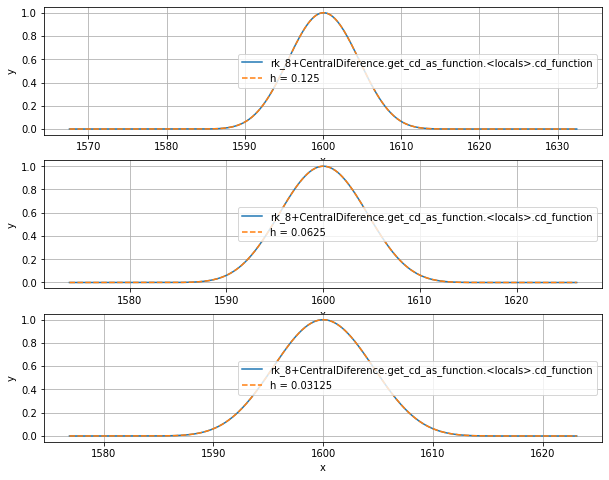

In [17]:
c = 1. 
L = 3000
r = 1.
#H = [0.125, 0.0625]
H = [1/8, 1/16, 1/32]
err_packs = make_error_packs(H, c, L, r, [rk_8], [cd_8], pw = 8, draw = True)

[array([6.03378984e-12, 6.43409089e-14, 5.24533862e-14])]


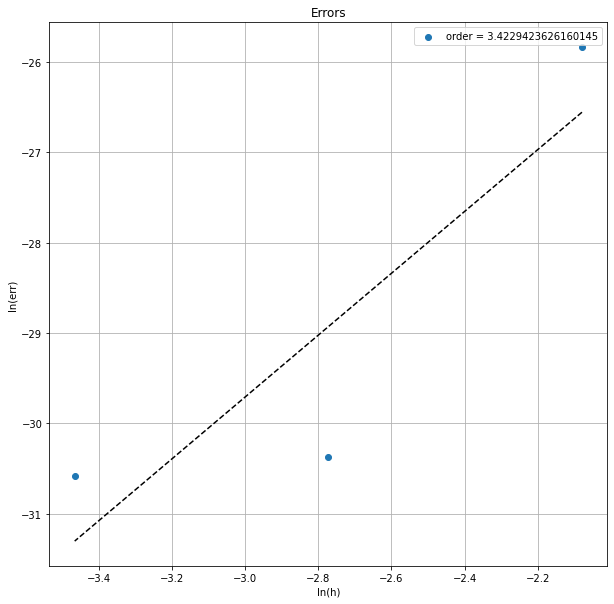

In [18]:
print(err_packs)
plot_errors(H, err_packs)